my code on machine A finishes training, and is exported as an onnx. It is linked to an s3 model so it's saved there automatically.

on machine B, I have a git repo with a python script that takes an argument for a path, it imports the model from that path and serves it on a fastapi server. In that repo I also have a docker file that takes a model id, that when built installs the required dependencies and then downloads the model from the s3 bucket and saves it to the path (meaning the model is only downloaded once but it imported at every cold start). In that repo there's also a github actions pipeline, that upon a push runs the build for the docker image (this is done on github's compute services). The pipeline also then logs into eccr using a secret that I have stored on github, then it pushes that built docker image to an ecr repo that I created manually earlier. The pipeline then tells the lambda function to update it's reference to ecr.

include cloudwatch for logging.
Include some testing

# NGROK and MLFLOW

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
from google.colab import userdata

auth_token = userdata.get("ngrok") # grabs secret
ngrok.set_auth_token(auth_token) # sets up the token from secrets, use  to kill
ngrok.kill() # kill any process already running

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.0 MB/s eta 0:00:00


In [ ]:
get_ipython().system_raw('mlflow ui --port 7000 &') # runs the command "!mlflow ui -port 7000", the & runs it in the backgroud (needed here instead of !)

# use "get_ipython().system_raw('mlflow server stop') to stop

In [ ]:
tunnel = ngrok.connect(7000)
print(f"Ngrok tunnel URL: {tunnel.public_url}")

Ngrok tunnel URL: https://417252f25767.ngrok-free.app


In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 133.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.7 MB/s eta 0:00:00


In [ ]:
import boto3

boto3.setup_default_session(
    aws_access_key_id=userdata.get("mlflow_access_key"),
    aws_secret_access_key=userdata.get("mlflow_secret_access_key"),
    region_name=userdata.get("mlflow_region") )


In [ ]:
import mlflow

expirement_name = "my_experiment2"
s3_bucket_name = "s3://resnetezz"

experiment_id = mlflow.create_experiment(
    name= expirement_name ,
    artifact_location=s3_bucket_name
)

expriment_info = mlflow.set_experiment(expirement_name)

# Torch Code

In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
from copy import deepcopy

In [ ]:
print("gpu available: ", torch.cuda.is_available())

gpu available:  True


In [ ]:
fixed_params = {
    "max_epochs": 6,
    "max_lr": 1e-3,
    "batch_size": 128,
    "weight_decay": 1e-4,
    "patience": 2,
}

hyper_param_range = [2,4,8]

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transforms.ToTensor())
val_set = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=fixed_params["batch_size"],shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=fixed_params["batch_size"],shuffle=True)


100%|██████████| 170M/170M [00:01<00:00, 90.4MB/s]


In [ ]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

number of training batchs: 391
number of validation batchs: 79
data shapes: torch.Size([128, 3, 32, 32]) torch.Size([128])
sample class: deer


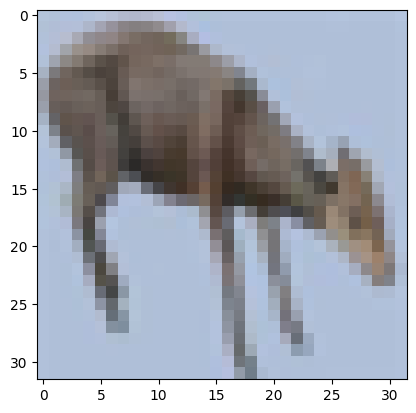

In [ ]:
print(f"number of training batchs: {len(train_loader)}")
print(f"number of validation batchs: {len(val_loader)}")

x_batch_sample, y_batch_sample = next(iter(train_loader))
print("data shapes:", x_batch_sample.shape, y_batch_sample.shape)
plt.imshow(x_batch_sample[0].permute(1, 2, 0))
print("sample class:", CLASSES[y_batch_sample[0].item()])

In [ ]:
class Block(nn.Module):
  def __init__(self, channels, kernel_size):
    super().__init__()
    self.channels = channels
    self.conv_1 = (nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=1))
    self.bn_1 = nn.BatchNorm2d(channels)
    self.relu_1 = nn.ReLU()

    self.conv_2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=1)
    self.bn_2 = nn.BatchNorm2d(channels)
    self.relu_2 = nn.ReLU()

  def forward(self, x):
    resid = x
    x = self.conv_1(x)
    x = self.bn_1(x)
    x = self.relu_1(x)
    x = self.conv_2(x)
    x = self.bn_2(x)
    x = x + resid
    return self.relu_2(x)

class DownSampleBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=2)
    self.bn_1 = nn.BatchNorm2d(out_channels)
    self.relu_1 = nn.ReLU()
    self.conv_2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1)
    self.bn_2 = nn.BatchNorm2d(out_channels)
    self.relu_2 = nn.ReLU()

    self.proj = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, padding=0, bias=False)


  def forward(self, x):
    assert len(x.shape) == 4
    N,C,H,W = x.shape
    assert C == self.in_channels
    assert H == W and H % 2 == 0 and W % 2 == 0

    resid = self.proj(x)
    x = self.conv_1(x)
    x = self.bn_1(x)
    x = self.relu_1(x)
    x = self.conv_2(x)
    x = self.bn_2(x)
    x = x + resid
    return self.relu_2(x)

class ResNet(nn.Module):
  def __init__(self, n):
    super().__init__()
    self.n = n
    conv = [nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), nn.BatchNorm2d(16),nn.ReLU()]

    for i in range(self.n):
      conv.append(Block(channels=16, kernel_size=3))

    conv.append(DownSampleBlock(in_channels=16, out_channels=32, kernel_size=3))
    for i in range(1,self.n):
      conv.append(Block(channels=32, kernel_size=3))

    conv.append(DownSampleBlock(in_channels=32, out_channels=64, kernel_size=3))
    for i in range(1,self.n):
      conv.append(Block(channels=64, kernel_size=3))
    self.conv = nn.Sequential(*conv)

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
      x = self.conv(x)
      x = self.avg_pool(x)
      x = x.view(x.shape[0], -1) # flatten
      logits = self.fc(x)
      return logits

In [ ]:
#del my_model

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'using {device}')

using cuda


In [ ]:
my_model = ResNet(hyper_param_range[0])
my_model = my_model.to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = optim.AdamW(my_model.parameters(), lr=fixed_params["max_lr"], weight_decay=fixed_params["weight_decay"])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=fixed_params["max_epochs"]*len(train_loader))

In [ ]:
""" sample sanity check on model """

x_batch_sample = x_batch_sample.to(device)
y_batch_sample = y_batch_sample.to(device)
logits_sample = my_model(x_batch_sample)
loss_sample = loss_fn(logits_sample, y_batch_sample)
max_logit_value_sample, predicted_class_index_sample = torch.max(logits_sample, dim=1)
accuracy_sample = torch.mean(torch.eq(predicted_class_index_sample, y_batch_sample).float()).item()

print(f'Output Shape: {my_model(x_batch_sample).shape}')
print(f'Initial batch training loss: {loss_sample}')
print(f'Initial batch training accuracy: {accuracy_sample}')
total_params = sum(p.numel() for p in my_model.parameters())
print(f'Total number of parameters: {total_params}')

Output Shape: torch.Size([128, 10])
Initial batch training loss: 2.3242201805114746
Initial batch training accuracy: 0.15625
Total number of parameters: 175530


# Training Code

In [ ]:
@torch.no_grad()
def validation(val_loader):
  """ iterate over the entire validation set. Returns average validation loss and accuracy """

  assert torch.cuda.is_available(), "CUDA is not available. Training without GPU is not recommended. Switch to a GPU"
  loss_val_sum, accuracy_val_sum, batches_done = 0, 0, 0

  my_model.eval()
  for x_batch_val, y_batch_val in val_loader:

    x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
    with torch.amp.autocast('cuda', dtype=torch.bfloat16): # use bfloat16 for faster forward pass
      logits_val = my_model(x_batch_val)
      loss_val = loss_fn(logits_val, y_batch_val)

    max_logit_value_val, predicted_class_index_val = torch.max(logits_val, dim=1)
    accuracy_val_sum += torch.mean(torch.eq(predicted_class_index_val, y_batch_val).float()).item()

    loss_val_sum += loss_val.item()
    batches_done += 1

  my_model.train()
  return loss_val_sum/batches_done , accuracy_val_sum/batches_done

In [ ]:
best_val_loss = float('inf')
best_model_state = None # keeps a copy of the best model at the end of every epoch
epochs_no_improvement = 0

lrs = []
losses = []

assert torch.cuda.is_available(), "CUDA is not available. Switch to a GPU"


for j in range(fixed_params["max_epochs"]):
  print(f'starting epoch: {j}')
  batches_done,  epoch_train_losses_sum, epoch_train_accuracies_sum  = 0, 0, 0

  my_model.train()
  for x_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad(set_to_none=True)

    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
      logits = my_model(x_batch)
      loss = loss_fn(logits, y_batch)

    loss.backward()
    optimizer.step()
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    losses.append(loss.item())
    lrs.append(current_lr)

    with torch.no_grad():
      """ get batch accuracy """
      max_logit_value, predicted_class_index = torch.max(logits, dim=1)
      accuracy = torch.mean(torch.eq(predicted_class_index, y_batch).float()).item()

    """ add batch statistics to epoch statistics """
    epoch_train_losses_sum += loss.item()
    epoch_train_accuracies_sum += accuracy
    batches_done += 1

  """ end of epoch statistics """
  epoch_train_loss = epoch_train_losses_sum/batches_done # compute batch averages
  epoch_train_accuracy  = epoch_train_accuracies_sum/batches_done
  print(f'train loss: {epoch_train_loss}, train accuracy: {epoch_train_accuracy *100}')
  epoch_val_loss, epoch_val_accuracy = validation(val_loader) # compute validation loss
  print(f'validation loss: {epoch_val_loss}, validation accuracy: {epoch_val_accuracy*100}')

  """ early stopping checls """
  if epoch_val_loss < best_val_loss:
    best_val_loss = epoch_val_loss
    best_model_state = deepcopy(my_model.state_dict())
    epochs_no_improvement = 0
  else:
    epochs_no_improvement += 1
  if epochs_no_improvement >= fixed_params["patience"]: # early stopping
    print(f"Early stopping at epoch {j}")
    break

my_model.load_state_dict(best_model_state) # set the model to the best model

starting epoch: 0


100%|██████████| 391/391 [00:11<00:00, 34.22it/s]


train loss: 1.3770592743173584, train accuracy: 49.13443095238922
validation loss: 1.235022083113465, validation accuracy: 54.96439873417721
starting epoch: 1


100%|██████████| 391/391 [00:10<00:00, 37.48it/s]


train loss: 0.9660345593376842, train accuracy: 65.12068414017368
validation loss: 0.9771922034553334, validation accuracy: 64.44818037974683
starting epoch: 2


100%|██████████| 391/391 [00:10<00:00, 37.53it/s]


train loss: 0.7895509859789973, train accuracy: 71.99008951101766
validation loss: 0.8163321040853669, validation accuracy: 70.95530063291139
starting epoch: 3


100%|██████████| 391/391 [00:10<00:00, 37.66it/s]


train loss: 0.658404675057477, train accuracy: 76.85621803069054
validation loss: 0.7738267326656776, validation accuracy: 72.54746835443038
starting epoch: 4


100%|██████████| 391/391 [00:10<00:00, 37.72it/s]


train loss: 0.5631322570316627, train accuracy: 80.43797953659312
validation loss: 0.6497508502459224, validation accuracy: 77.18552215189874
starting epoch: 5


100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


train loss: 0.5126190622291906, train accuracy: 82.40728901170404
validation loss: 0.6398212257065351, validation accuracy: 77.66020569620254


<All keys matched successfully>

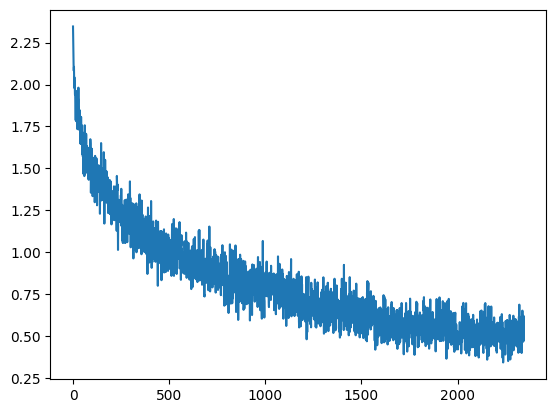

In [ ]:
plt.plot(losses)

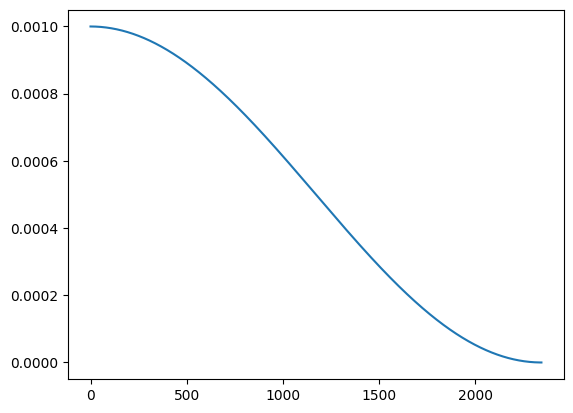

In [ ]:

plt.plot(lrs)
plt.yscale('linear')

In [ ]:
!pip install onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.9/660.9 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
""" export the best model """

import onnx, onnxscript, onnxruntime

my_model.eval()
my_model.cpu()
example_input_tensor = x_batch_sample[0].view(1,3,32,32).cpu()
example_input_numpy = x_batch_sample[0].view(1,3,32,32).cpu().numpy()
onnx_path = "model.onnx" # name to be stored to disk
torch.onnx.export(my_model, example_input_tensor, onnx_path, opset_version=18, dynamo=True, output_names=["logits"]) # store to disk using newer dynamo exporter,
                                                                                                                     # opset 18 was released in 2023
onnx_model = onnx.load(onnx_path)

model_name = "my_model"

with mlflow.start_run() as run:
  info = mlflow.onnx.log_model(onnx_model=onnx_model,input_example=example_input_numpy,name=model_name)
  s3_model_uri = mlflow.get_artifact_uri()
  S3_MODEL_URI = f"{s3_bucket_name}/models/{info.model_uuid}/artifacts"
  print(f"S3_MODEL_URI={S3_MODEL_URI}") # use this in inference code to pull the model

[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
S3_MODEL_URI=s3://resnetezz/models/m-613deb2865bf472fa1bd22591200aae2/artifacts


# Running inference

In [ ]:
from PIL import Image
import io
import numpy as np

In [ ]:
S3_MODEL_URI = "s3://resnetezz/models/m-613deb2865bf472fa1bd22591200aae2/artifacts"

In [ ]:
pyfunc_model = mlflow.pyfunc.load_model(S3_MODEL_URI)

In [ ]:
def transform_PIL_image(img):
  img = img.resize((32,32))
  img_data = np.array(img).astype(np.float32)  # shape (H, W, C)
  img_data = np.transpose(img_data, (2, 0, 1))   # change shape to (C, H, W) based on model expectation
  img_data /= 255.0 # normalize
  img_data = np.expand_dims(img_data, axis=0) # fit into a single batch tensor for inference
  return img_data

def predict(img):
  global pyfunc_model, CLASSES
  img_data = transform_PIL_image(img)
  model_output = pyfunc_model.predict(img_data)
  logits = model_output['logits'][0] # extract output from dict, and then take the first batch
  top_class = CLASSES[int(np.argmax(logits))]
  prediction = {"top_class": top_class, "logits":logits.tolist()}
  return prediction

{'top_class': 'frog',
 'logits': [-2.3014562129974365,
  -1.9435274600982666,
  -1.6174864768981934,
  -1.4676148891448975,
  -1.5648701190948486,
  -3.4737062454223633,
  4.359997272491455,
  -3.2426998615264893,
  -4.4718427658081055,
  -2.7609081268310547]}

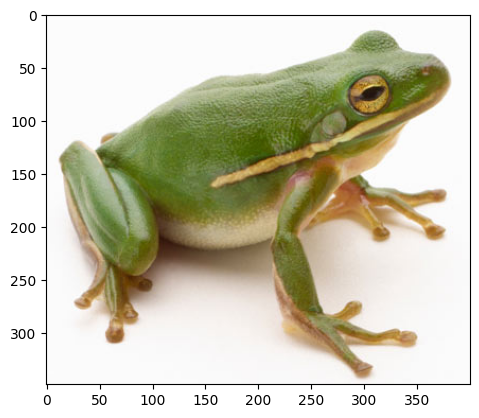

In [ ]:
""" out of distribution sample inference test """
sample_img = Image.open("frog.jpg")
plt.imshow(sample_img)
predict(sample_img)